In [9]:
import sys
import numpy as np 
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from copy import deepcopy
from ipywidgets import IntProgress
from IPython.display import display
sys.path.append('E:/Pythonworkshop/Equation_Bys/machine-scientist/')
sys.path.append('E:/Pythonworkshop/Equation_Bys/machine-scientist//Prior/')
from mcmc import *
from parallel import *
from fit_prior import read_prior_par


In [10]:
np.random.seed(42)
x1 = np.random.uniform(-3, 3, 500)
x2 = np.random.uniform(0.1, 3, 500)

# 设定新的更复杂的目标公式：
# y = sin(x1) + x1^3 + log(x2) + exp(x2)
true_y = np.sin(x1) + x1**3 + np.log(x2) + np.exp(-x2)

# 添加高斯噪声
noise = np.random.normal(0, 0.2, 500)  # 均值 0，标准差 0.2
y_noisy = true_y + noise

In [11]:

# 组织 DataFrame
data = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y_noisy})

# ========== 4. 读取先验参数 ==========
prior_par = read_prior_par('./Prior/final_prior_param_sq.named_equations.nv39.np39.maxs200.2024-09-04 17_12_47.626145.dat')

IntProgress(value=0, description='Running:', max=500)

IntProgress(value=0, description='Running:', max=3000)

Best model:	 ((((x1 ** 3) + sin(x1)) + (log(x2) * _a2_)) + _a0_)
Desc. length:	 -42.5278431392458


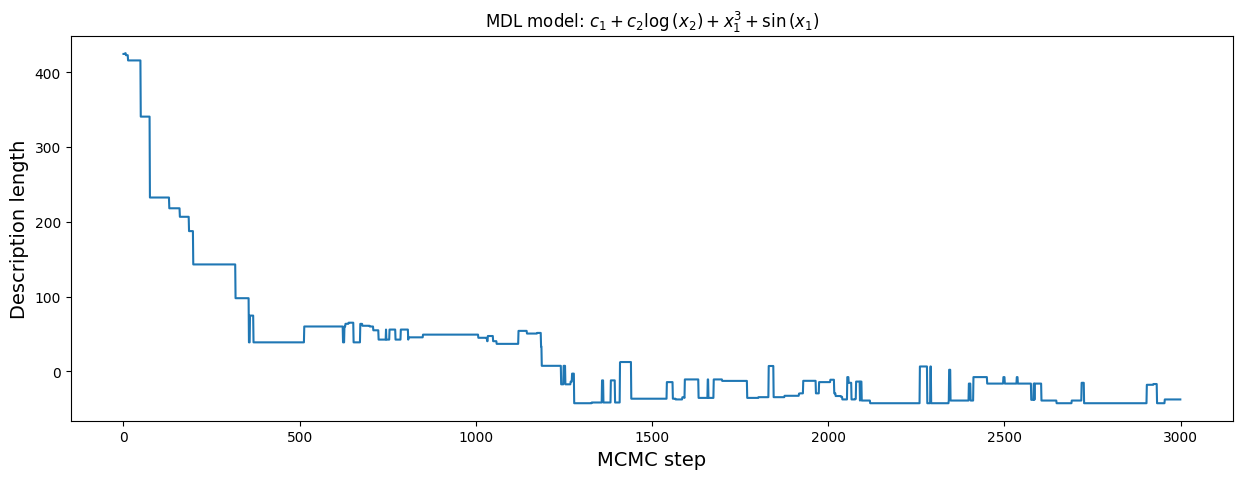

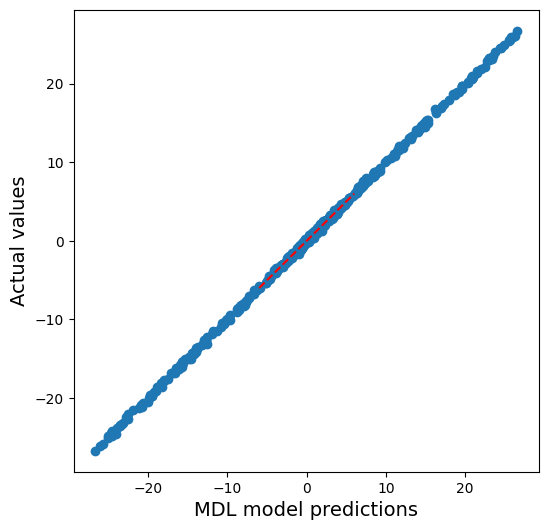

In [12]:

# ========== 5. 设定 MCMC 参数 ==========
Ts = [1] + [1.04**k for k in range(1, 20)]  # 温度参数
variables = ['x1', 'x2']
parameters = ['a%d' % i for i in range(5)]  # 假设最多 5 个参数

# ========== 6. 初始化 Bayesian 机器科学家 ==========
pms = Parallel(
    Ts,
    variables=variables,
    parameters=parameters,
    x=data[['x1', 'x2']], 
    y=data['y'],
    prior_par=prior_par,
)

# ========== 7. 执行 MCMC 采样（第一阶段，初步优化） ==========
nstep = 500
f = IntProgress(min=0, max=nstep, description='Running:')
display(f)

for i in range(nstep):
    pms.mcmc_step()
    pms.tree_swap()
    f.value += 1

# ========== 8. 继续 MCMC 采样（第二阶段，深入优化） ==========
nstep = 3000
f = IntProgress(min=0, max=nstep, description='Running:')
display(f)

description_lengths, mdl, mdl_model = [], np.inf, None

for i in range(nstep):
    pms.mcmc_step()
    pms.tree_swap()
    
    description_lengths.append(pms.t1.E)
    
    if pms.t1.E < mdl:
        mdl, mdl_model = pms.t1.E, deepcopy(pms.t1)

    f.value += 1

# ========== 9. 输出最优模型 ==========
print('Best model:\t', mdl_model)
print('Desc. length:\t', mdl)

# ========== 10. 绘制 MCMC 过程中的描述长度收敛情况 ==========
plt.figure(figsize=(15, 5))
plt.plot(description_lengths)
plt.xlabel('MCMC step', fontsize=14)
plt.ylabel('Description length', fontsize=14)
plt.title('MDL model: $%s$' % mdl_model.latex())
plt.show()

# ========== 11. 计算并绘制预测值 vs. 真实值 ==========
plt.figure(figsize=(6, 6))
plt.scatter(mdl_model.predict(data[['x1', 'x2']]), data['y'])
plt.plot((-6, 6), (-6, 6), 'r--')  # 对角线
plt.xlabel('MDL model predictions', fontsize=14)
plt.ylabel('Actual values', fontsize=14)
plt.show()
